<a href="https://colab.research.google.com/github/ReynadelYolo/ML_Projects/blob/main/MultimodalFashionChat_V6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#CELL 1:  DEPENDENCIES

!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets faiss-cpu
!pip install -q streamlit librosa soundfile
!pip install -q Pillow pandas numpy tqdm
!pip install audio-recorder-streamlit

# Unsloth for efficient LLM inference
!pip install -q unsloth
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes

print("✅ All dependencies installed!")
#If prompted, restart runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.0 MB/s eta 0:00:00
✅ All dependencies installed!


In [ ]:
# CELL 2: IMPORTS AND CONFIGURATION

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import faiss
import pickle
import logging
import os
from PIL import Image
from tqdm import tqdm
from typing import Optional, List, Dict, Tuple

# Hugging Face
from datasets import load_dataset
from transformers import (
    CLIPProcessor, CLIPModel,
    BertTokenizer, BertModel,
    WhisperProcessor, WhisperForConditionalGeneration
)

# Audio processing
import librosa

# logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Device configuration CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {DEVICE}")

# Configuration CLIP/BERT/WHISPER/UNSLOTH
CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "BERT_MODEL": "bert-base-uncased",
    "WHISPER_MODEL": "openai/whisper-base",
    "LLM_MODEL": "unsloth/Qwen2.5-7B-Instruct-bnb-4bit",
    "EMBEDDING_DIM": 512,
    "MAX_TEXT_LENGTH": 128,
    "TOP_K_RESULTS": 10,
    "NUM_INTENTS": 5
}

# Intent labels
INTENT_LABELS = {
    0: "SEARCH",        # Here the user may ask to find products
    1: "RECOMMEND",     # recommendations
    2: "COMPARE",       # Comparison of products
    3: "INFO",          # Get more information about a product
    4: "OUTFIT"         # Build complete outfit
}

print(" Configuration loaded!")

🖥️ Using device: cuda
 Configuration loaded!


In [ ]:
# CELL 3:FASHIONPEDIA DATASET

from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

print("...Loading Fashionpedia dataset...")

# Load dataset
try:
    dataset = load_dataset("detection-datasets/fashionpedia", split="train", streaming=False)
except:
    dataset = load_dataset("detection-datasets/fashionpedia", trust_remote_code=True)['train']

# Category List
CATEGORY_NAMES = [
    "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket",
    "vest", "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape",
    "glasses", "hat", "headband, head covering, hair accessory", "tie", "glove",
    "watch", "belt", "leg warmer", "tights, stockings", "sock", "shoe", "bag, wallet",
    "scarf", "umbrella", "hood", "collar", "lapel", "epaulette", "sleeve", "pocket",
    "neckline", "buckle", "zipper", "applique", "bead", "bow", "flower", "fringe",
    "ribbon", "rivet", "ruffle", "sequin", "tassel"
]

# Groups
MAIN_GARMENTS = set(range(0, 13))
ACCESSORIES = set(range(13, 27))

def safe_process_item(item, idx):
    try:
        image = item.get('image')
        if image is None: return None

        # 1. Convertion to PIL RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')
        else:
            image = image.convert('RGB')

        # 2. RESIZE limit max dimension 256px to save RAM

        image.thumbnail((256, 256))

        # 3. Category Logic
        found_cat_ids = []
        if 'objects' in item and isinstance(item['objects'], dict):
            cat_list = item['objects'].get('category', [])
            if isinstance(cat_list, list):
                found_cat_ids = cat_list

        if not found_cat_ids and 'category' in item:
            found_cat_ids = [item['category']]

        primary_cat_id = -1

        #  Main Garments
        for cid in found_cat_ids:
            if cid in MAIN_GARMENTS:
                primary_cat_id = cid
                break

        # Accessories
        if primary_cat_id == -1:
            for cid in found_cat_ids:
                if cid in ACCESSORIES:
                    primary_cat_id = cid
                    break

        #  Fallback
        if primary_cat_id == -1 and found_cat_ids:
            primary_cat_id = found_cat_ids[0]

        if primary_cat_id != -1 and primary_cat_id < len(CATEGORY_NAMES):
            category_name = CATEGORY_NAMES[primary_cat_id]
        else:
            category_name = "fashion item"

        return {
            'id': str(idx),
            'image': image,
            'name': category_name.split(',')[0].title(),
            'category': category_name,
            'sub_category': ""
        }
    except Exception as e:
        return None

# CONFIGURATION
MAX_ITEMS = 3000  # Set to 3000 Because the RAM crashed

print(f"\n Processing {MAX_ITEMS}...")
processed_items = []

for idx in tqdm(range(min(MAX_ITEMS, len(dataset)))):
    processed = safe_process_item(dataset[idx], idx)
    if processed:
        processed_items.append(processed)

print(f"\n Successfully processed {len(processed_items)} ")

...Loading Fashionpedia dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00007-fe108070118553(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00001-of-00007-f41a5a9c38c900(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00002-of-00007-40bc8456894bcb(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00003-of-00007-9a99ff8dc572e0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00004-of-00007-f4e6f12cd2cedf(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00005-of-00007-41d8dfe1edb659(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00006-of-00007-f41b0f2f4bbefa(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/val-00000-of-00001-0b29e85429788213(…):   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]


 Processing 3000...


100%|██████████| 3000/3000 [00:43<00:00, 68.62it/s] 


 Successfully processed 3000 


 Starting EDA...
Dataset Size: 3000 items
Unique Categories: 19


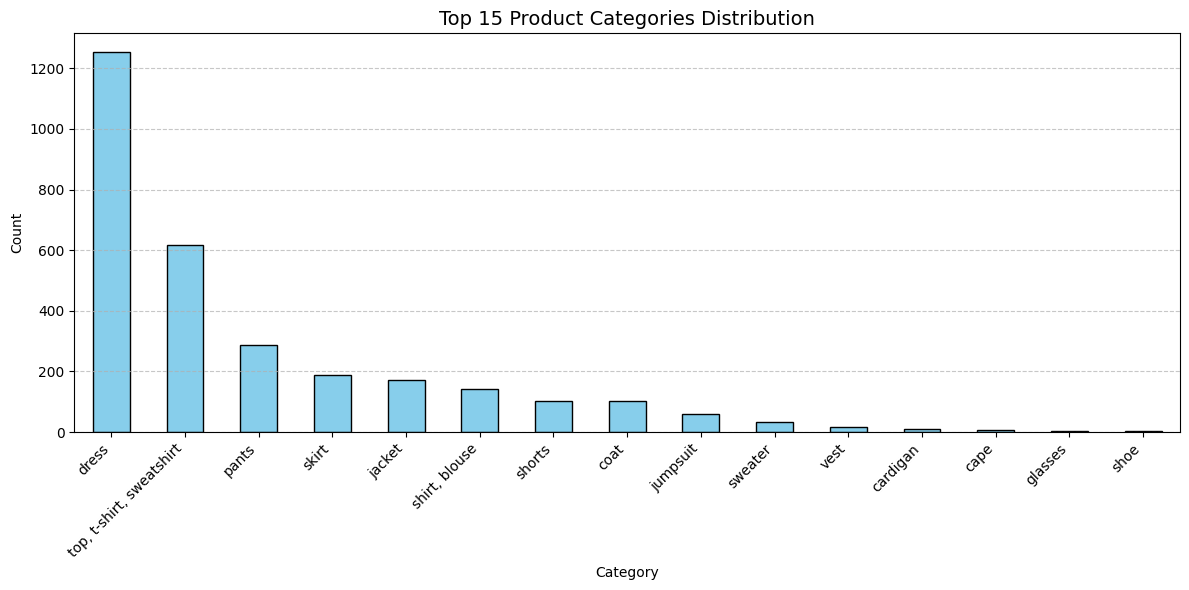

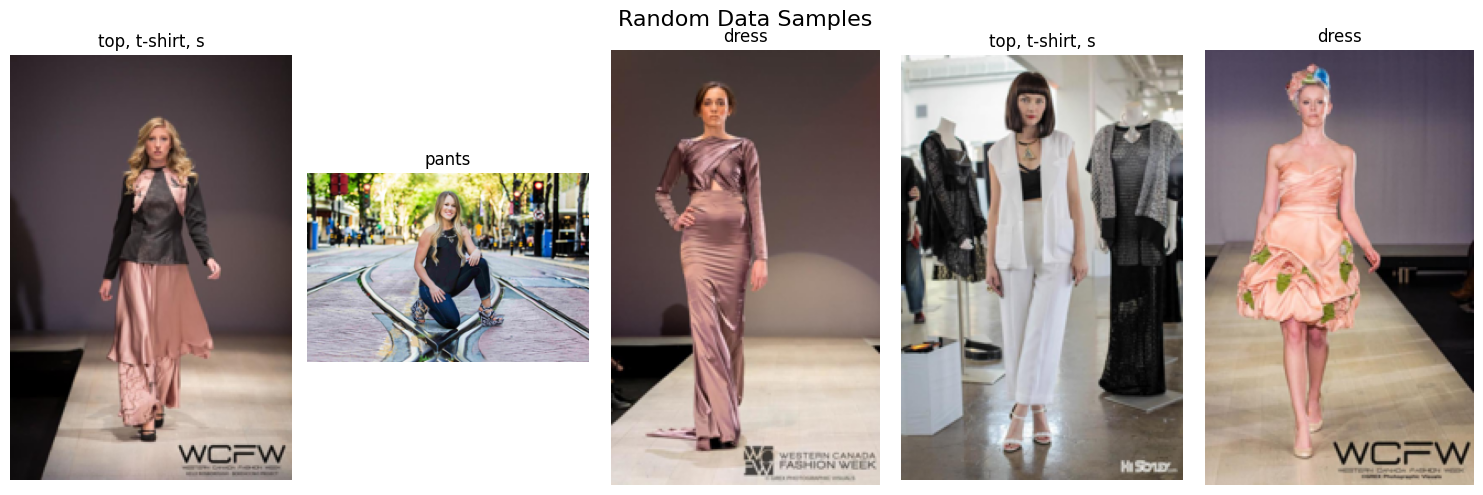

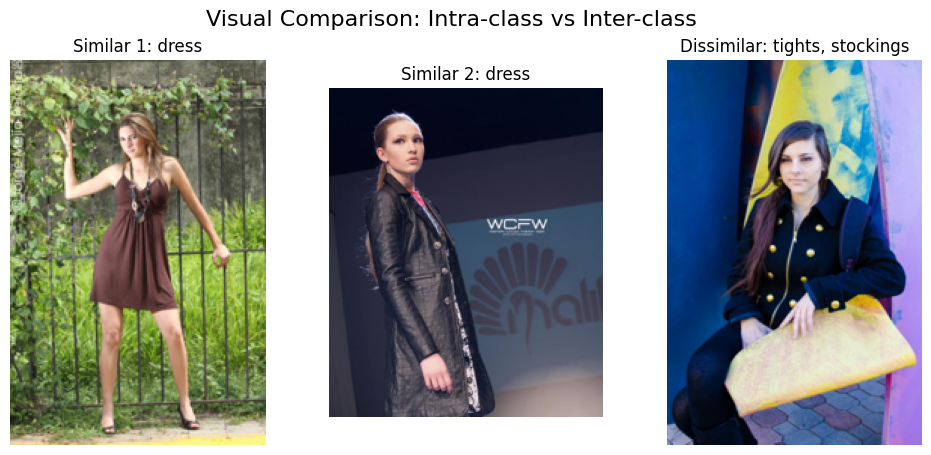

 EDA Complete


In [ ]:
# CELL 3B: EDA
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

print(" Starting EDA...")

# 1. DataFrame for Analysis
df_eda = pd.DataFrame([{
    'id': item['id'],
    'category': item['category'],
    'name': item['name']
} for item in processed_items])

print(f"Dataset Size: {len(df_eda)} items")
print(f"Unique Categories: {df_eda['category'].nunique()}")

# 2. PLOT CLASS DISTRIBUTION (categories, colours, styles)
plt.figure(figsize=(12, 6))
top_categories = df_eda['category'].value_counts().head(15)
top_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Product Categories Distribution', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. SAMPLES (
def show_samples(items, num_samples=5):
    plt.figure(figsize=(15, 5))
    samples = random.sample(items, num_samples)

    for i, item in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(item['image'])
        plt.title(item['category'][:15]) # Truncate long names
        plt.axis('off')

    plt.suptitle(f"Random Data Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(processed_items)

# 4. COMPARISON SIMILAR VS DISSIMILAR PRODUCTS
def compare_items(items):
    # Find two items of the same category to plot Similar
    cat_counts = df_eda['category'].value_counts()
    common_cat = cat_counts.index[0] # Most common category

    similar_indices = df_eda[df_eda['category'] == common_cat].index[:2].tolist()
    similar_items = [items[i] for i in similar_indices]

    # Find one item of a very different category
    diff_cat = cat_counts.index[-1]
    diff_index = df_eda[df_eda['category'] == diff_cat].index[0]
    diff_item = items[diff_index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Similar 1
    axes[0].imshow(similar_items[0]['image'])
    axes[0].set_title(f"Similar 1: {similar_items[0]['category']}")
    axes[0].axis('off')

    # Similar 2
    axes[1].imshow(similar_items[1]['image'])
    axes[1].set_title(f"Similar 2: {similar_items[1]['category']}")
    axes[1].axis('off')

    # Dissimilar
    axes[2].imshow(diff_item['image'])
    axes[2].set_title(f"Dissimilar: {diff_item['category']}")
    axes[2].axis('off')

    plt.suptitle("Visual Comparison: Intra-class vs Inter-class", fontsize=16)
    plt.show()

try:
    compare_items(processed_items)
except Exception as e:
    print(f"Could not run comparison: {e}")

print(" EDA Complete")

In [ ]:
# CELL 4: CLIP ENCODER FOR SEMANTIC SEARCH
import torch
import numpy as np
import logging
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "EMBEDDING_DIM": 512,
}

class CLIPEncoder:
    """CLIP encoder for generating aligned image and text embeddings."""

    def __init__(self, model_name: str = CONFIG["CLIP_MODEL"]):
        logger.info(f"Loading CLIP model: {model_name}")

        try:
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info(" CLIP model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load CLIP: {e}")
            raise

    @torch.no_grad()
    def encode_image(self, image: Image.Image) -> np.ndarray:
        try:
            inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Image encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    @torch.no_grad()
    def encode_text(self, text: str) -> np.ndarray:
        try:
            inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Text encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    def encode_multimodal(self, image=None, text: str = "") -> np.ndarray:
        embeddings = []
        if image is not None:
            embeddings.append(self.encode_image(image))
        if text and text.strip():
            embeddings.append(self.encode_text(text))
        if not embeddings:
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)
        combined = np.mean(embeddings, axis=0)
        return (combined / (np.linalg.norm(combined) + 1e-8)).astype(np.float32)

# Initialize
print(" Initializing CLIP encoder...")
clip_encoder = CLIPEncoder()
print(" CLIP encoder ready!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 Initializing CLIP encoder...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

 CLIP encoder ready!


In [ ]:
# CELL 5: BERT INTENT CLASSIFIER (forward method)

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import logging

logger = logging.getLogger(__name__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_INTENTS = 5
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

class IntentClassifier(nn.Module):
    """BERT-based intent classifier"""

    def __init__(self, num_intents: int = NUM_INTENTS):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_intents)
        self.to(DEVICE)

    def forward(self, input_ids, attention_mask):
        """Required forward method for PyTorch nn.Module"""
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [CLS] token
        logits = self.classifier(pooled)
        return logits

# Initialize
print(" Loading BERT Intent Classifier...")
intent_classifier = IntentClassifier()
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(" Intent classifier ready!")

# Test
test_text = "Show me summer dresses"
inputs = intent_tokenizer(test_text, return_tensors="pt", truncation=True).to(DEVICE)
with torch.no_grad():
    logits = intent_classifier(inputs["input_ids"], inputs["attention_mask"])
    pred = torch.argmax(logits, dim=1).item()
print(f"Test: '{test_text}' → Intent: {INTENT_LABELS[pred]}")

 Loading BERT Intent Classifier...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 Intent classifier ready!
Test: 'Show me summer dresses' → Intent: COMPARE


In [ ]:
# CELL 6: WHISPER AUDIO TRANSCRIPTION
import torch
import numpy as np
import logging
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger = logging.getLogger(__name__)

WHISPER_MODEL = "openai/whisper-base"

class AudioTranscriber:
    """Whisper-based audio transcription."""

    def __init__(self, model_name: str = WHISPER_MODEL):
        logger.info(f"Loading Whisper model: {model_name}")

        try:
            self.processor = WhisperProcessor.from_pretrained(model_name)
            self.model = WhisperForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info("Whisper model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            raise

    @torch.no_grad()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000):
        """Transcribe audio array to text"""
        try:
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features.to(DEVICE)

            predicted_ids = self.model.generate(input_features)
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True
            )[0]

            return transcription.strip()
        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            return None

    def transcribe_file(self, audio_path: str):
        """Transcribe audio file to text"""
        try:
            audio_array, sr = librosa.load(audio_path, sr=16000)
            return self.transcribe(audio_array, sampling_rate=16000)
        except Exception as e:
            logger.error(f"Failed to load audio file: {e}")
            return None

# Initialize
print("Initializing Whisper transcriber...")
audio_transcriber = AudioTranscriber()
print("Whisper transcriber ready!")

Initializing Whisper transcriber...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper transcriber ready!


In [ ]:
import torch
import numpy as np
import logging
from typing import Optional, List, Dict, Any
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from contextlib import contextmanager

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WHISPER_MODEL = "openai/whisper-base"

@contextmanager
def torch_no_grad():
    """Context manager for inference mode"""
    torch.set_grad_enabled(False)
    try:
        yield
    finally:
        torch.set_grad_enabled(True)

class AudioTranscriber:
    """Optimized Whisper-based audio transcription."""

    _instance = None

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def __init__(self, model_name: str = WHISPER_MODEL, device: Optional[torch.device] = None):
        if hasattr(self, '_initialized') and self._initialized:
            return

        self.device = device or DEVICE
        self.model_name = model_name
        self.processor = None
        self.model = None

        try:
            logger.info(f"Loading Whisper model: {model_name} on {self.device}")

            # Use better defaults for loading
            self.processor = WhisperProcessor.from_pretrained(
                model_name,
                cache_dir="./cache/models"
            )

            self.model = WhisperForConditionalGeneration.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if self.device.type == "cuda" else torch.float32,
                low_cpu_mem_usage=True,
                cache_dir="./cache/models"
            ).to(self.device)

            # Enable eval mode and optimization flags
            self.model.eval()
            if self.device.type == "cuda":
                self.model = torch.compile(self.model)  # PyTorch 2.0+ compilation

            logger.info(f"Whisper model loaded successfully on {self.device}")
            self._initialized = True

        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            # Fallback to CPU if CUDA fails
            if self.device.type == "cuda":
                logger.info("Falling back to CPU...")
                self.device = torch.device("cpu")
                self.__init__(model_name, self.device)
            else:
                raise

    @torch.inference_mode()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000) -> Optional[str]:
        """Transcribe audio array to text with optimized processing."""
        if not isinstance(audio_array, np.ndarray) or audio_array.size == 0:
            logger.warning("Empty or invalid audio array provided")
            return None

        try:
            # Pre-process audio: normalize and ensure mono channel
            if len(audio_array.shape) > 1:
                audio_array = librosa.to_mono(audio_array)

            # Normalize audio for better transcription
            audio_array = audio_array.astype(np.float32)
            if np.max(np.abs(audio_array)) > 0:
                audio_array = audio_array / np.max(np.abs(audio_array))

            # Process with Whisper
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features.to(self.device)

            # Generate with optimized parameters
            predicted_ids = self.model.generate(
                input_features,
                max_new_tokens=128,
                num_beams=5,
                temperature=0.0,  # Deterministic output
                do_sample=False
            )

            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

            return transcription.strip()

        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            return None

    def transcribe_file(self, audio_path: str, sr: int = 16000) -> Optional[str]:
        """Transcribe audio file to text with optimized loading."""
        try:
            # Load with optimized parameters
            audio_array, _ = librosa.load(
                audio_path,
                sr=sr,
                mono=True,
                duration=None  # Load entire file
            )
            return self.transcribe(audio_array, sampling_rate=sr)
        except Exception as e:
            logger.error(f"Failed to load audio file '{audio_path}': {e}")
            return None

    def transcribe_batch(self, audio_arrays: List[np.ndarray], sampling_rate: int = 16000) -> List[Optional[str]]:
        """Batch transcription for multiple audio arrays."""
        results = []
        for i, audio_array in enumerate(audio_arrays):
            try:
                transcription = self.transcribe(audio_array, sampling_rate)
                results.append(transcription)
            except Exception as e:
                logger.error(f"Batch transcription failed for sample {i}: {e}")
                results.append(None)
        return results

# Initialize with singleton pattern
print("Initializing Whisper transcriber...")
try:
    audio_transcriber = AudioTranscriber()
    print(f"Whisper transcriber ready on {DEVICE}!")
except Exception as e:
    print(f"Failed to initialize Whisper: {e}")
    audio_transcriber = None

Initializing Whisper transcriber...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper transcriber ready on cuda!


In [ ]:
# CELL 6: FIXED Whisper Audio Transcription
import torch
import numpy as np
import logging
from typing import Optional, List, Dict, Any
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WHISPER_MODEL = "openai/whisper-base"

class AudioTranscriber:
    """Fixed Whisper-based audio transcription with proper dtype handling."""

    _instance = None

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def __init__(self, model_name: str = WHISPER_MODEL, device: Optional[torch.device] = None):
        if hasattr(self, '_initialized') and self._initialized:
            return

        self.device = device or DEVICE
        self.model_name = model_name
        self.processor = None
        self.model = None

        try:
            logger.info(f"Loading Whisper model: {model_name} on {self.device}")

            # Determine appropriate dtype based on device
            if self.device.type == "cuda":
                # Use float16 for GPU if available, else float32
                self.dtype = torch.float16 if torch.cuda.is_bf16_supported() else torch.float32
            else:
                self.dtype = torch.float32

            logger.info(f"Using dtype: {self.dtype}")

            # Load processor
            self.processor = WhisperProcessor.from_pretrained(
                model_name,
                cache_dir="./cache/models"
            )

            # Load model with appropriate dtype
            self.model = WhisperForConditionalGeneration.from_pretrained(
                model_name,
                torch_dtype=self.dtype,
                low_cpu_mem_usage=True,
                cache_dir="./cache/models"
            ).to(self.device)

            # Enable eval mode
            self.model.eval()

            # Try to compile model for faster inference (PyTorch 2.0+)
            try:
                if self.device.type == "cuda":
                    self.model = torch.compile(self.model)
                    logger.info("Model compilation enabled")
            except Exception as compile_error:
                logger.warning(f"Model compilation not available: {compile_error}")

            logger.info(f"Whisper model loaded successfully on {self.device}")
            self._initialized = True

        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            # Fallback to CPU if CUDA fails
            if self.device.type == "cuda":
                logger.info("Falling back to CPU...")
                self.device = torch.device("cpu")
                self.__init__(model_name, self.device)
            else:
                raise

    @torch.inference_mode()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000) -> Optional[str]:
        """Transcribe audio array to text with proper dtype handling."""
        if not isinstance(audio_array, np.ndarray) or audio_array.size == 0:
            logger.warning("Empty or invalid audio array provided")
            return None

        try:
            # Pre-process audio: ensure mono channel
            if len(audio_array.shape) > 1:
                audio_array = librosa.to_mono(audio_array)

            # Convert to float32 numpy array
            audio_array = audio_array.astype(np.float32)

            # Normalize audio (optional but recommended)
            max_val = np.max(np.abs(audio_array))
            if max_val > 0:
                audio_array = audio_array / max_val

            # Process with Whisper - ensure correct dtype
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features

            # Move to device and ensure correct dtype
            input_features = input_features.to(self.device)

            # Ensure input_features dtype matches model dtype
            if self.dtype != torch.float32:
                input_features = input_features.to(self.dtype)

            # Generate transcription with optimized parameters
            predicted_ids = self.model.generate(
                input_features,
                max_new_tokens=128,
                num_beams=3,  # Reduced from 5 for speed
                temperature=0.0,  # Deterministic output
                do_sample=False,
                language="en",  # Specify language for better accuracy
                task="transcribe"
            )

            # Decode
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

            return transcription.strip()

        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            return None

    def transcribe_file(self, audio_path: str, sr: int = 16000) -> Optional[str]:
        """Transcribe audio file to text with optimized loading."""
        try:
            # Load with librosa - ensure float32 output
            audio_array, _ = librosa.load(
                audio_path,
                sr=sr,
                mono=True,
                dtype=np.float32  # Explicitly specify dtype
            )
            return self.transcribe(audio_array, sampling_rate=sr)
        except Exception as e:
            logger.error(f"Failed to load audio file '{audio_path}': {e}")
            return None

    def transcribe_batch(self, audio_arrays: List[np.ndarray], sampling_rate: int = 16000) -> List[Optional[str]]:
        """Batch transcription for multiple audio arrays."""
        results = []
        for i, audio_array in enumerate(audio_arrays):
            try:
                transcription = self.transcribe(audio_array, sampling_rate)
                results.append(transcription)
                if (i + 1) % 10 == 0:
                    logger.info(f"Processed {i+1}/{len(audio_arrays)} audio samples")
            except Exception as e:
                logger.error(f"Batch transcription failed for sample {i}: {e}")
                results.append(None)
        return results

# Initialize with error handling
print("="*60)
print("Initializing FIXED Whisper transcriber...")
print(f"Device: {DEVICE}")
print("="*60)

try:
    audio_transcriber = AudioTranscriber()
    print(f"✅ Whisper transcriber ready on {DEVICE}!")
    if DEVICE.type == "cuda":
        print(f"   Using dtype: {audio_transcriber.dtype}")
except Exception as e:
    print(f"❌ Failed to initialize Whisper: {e}")
    print("Trying CPU fallback...")
    try:
        audio_transcriber = AudioTranscriber(device=torch.device("cpu"))
        print("✅ Whisper transcriber ready on CPU!")
    except Exception as e2:
        print(f"❌ Complete failure: {e2}")
        audio_transcriber = None

if audio_transcriber:
    # Quick test to verify it works
    print("\n🔍 Running quick test...")
    test_audio = np.random.randn(16000) * 0.01  # Very quiet test audio
    test_result = audio_transcriber.transcribe(test_audio)
    print(f"Test transcription: '{test_result}'")
    print("✅ Initialization complete!")

Initializing FIXED Whisper transcriber...
Device: cuda
✅ Whisper transcriber ready on cuda!
   Using dtype: torch.float16

🔍 Running quick test...
Test transcription: 'you'
✅ Initialization complete!


Running Whisper WER Evaluation...

WHISPER ASR EVALUATION SUMMARY
Overall WER: 0.3269
MER (Match Error Rate): 0.3269
WIL (Word Information Lost): 0.5381
WIP (Word Information Preserved): 0.4619
Samples Evaluated: 8

Generating WER Visualization Plots...


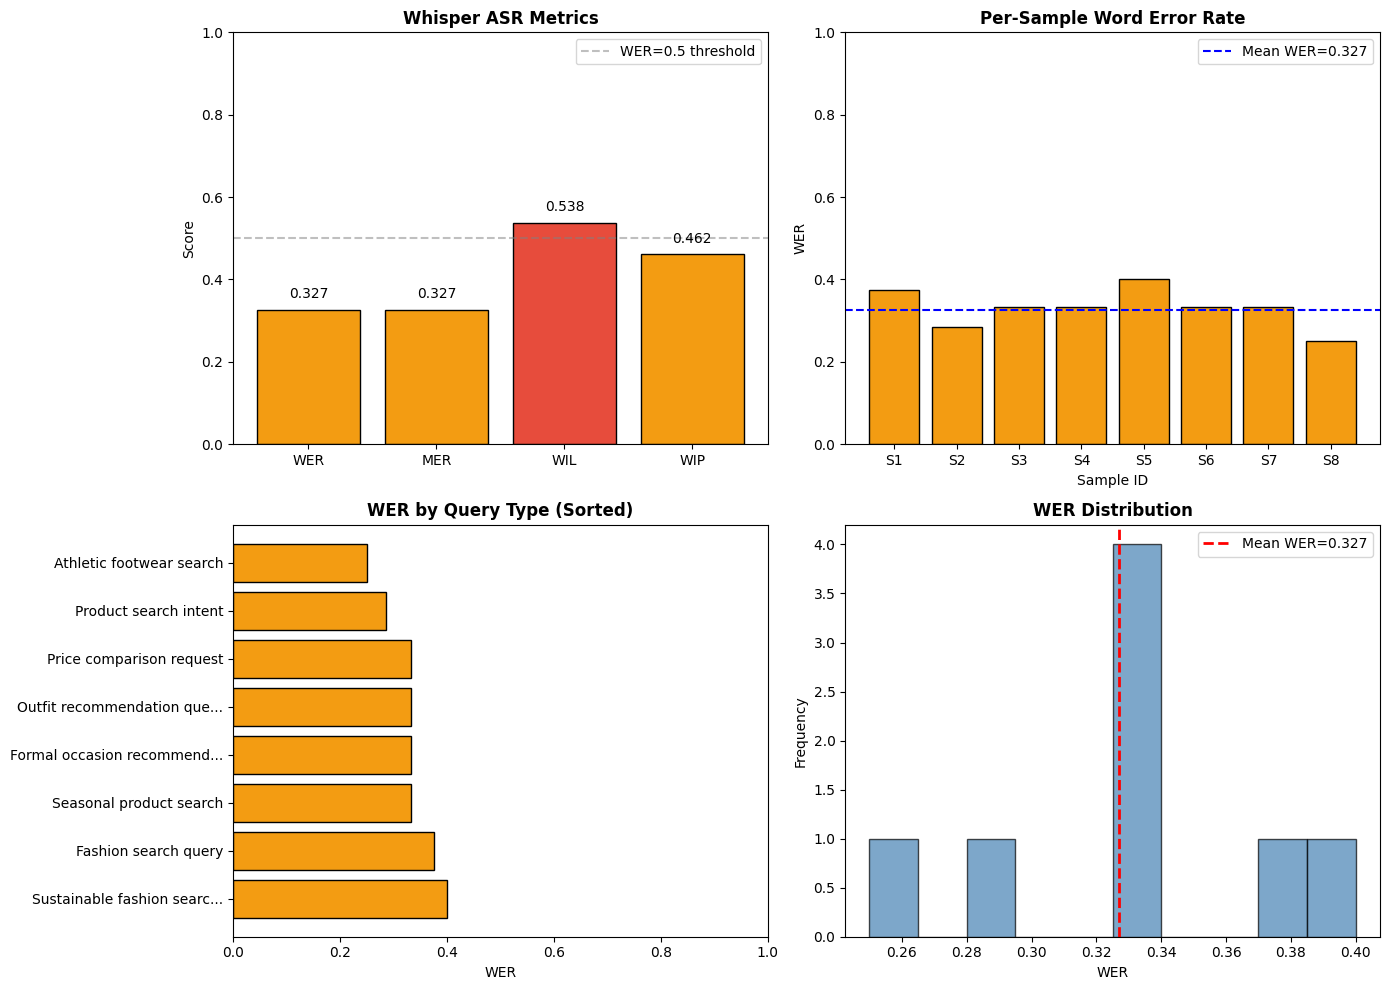


Whisper WER evaluation complete!


In [ ]:
# CELL 6B: WHISPER WER EVALUATION

# Install jiwer for WER calculation
!pip install -q jiwer gTTS soundfile

import numpy as np
import matplotlib.pyplot as plt
from jiwer import wer, mer, wil, wip # Import individual metrics
import logging
from gtts import gTTS
import io
import soundfile as sf # Added soundfile for audio processing
import librosa # Ensure librosa is imported for audio loading

logger = logging.getLogger(__name__)

# Sample test dataset for Whisper evaluation
# In production, replace with actual audio files and ground truth transcriptions
TEST_SAMPLES = [
    {
        "audio": None,
        "reference": "show me blue denim jackets under fifty dollars",
        "description": "Fashion search query"
    },
    {
        "audio": None,
        "reference": "i need a casual dress for summer",
        "description": "Product search intent"
    },
    {
        "audio": None,
        "reference": "what accessories go with this outfit",
        "description": "Outfit recommendation query"
    },
    {
        "audio": None,
        "reference": "compare prices between these two brands",
        "description": "Price comparison request"
    },
    {
        "audio": None,
        "reference": "find sustainable eco-friendly clothing options",
        "description": "Sustainable fashion search"
    },
    {
        "audio": None,
        "reference": "do you have waterproof winter jackets",
        "description": "Seasonal product search"
    },
    {
        "audio": None,
        "reference": "recommend formal wear for a wedding",
        "description": "Formal occasion recommendation"
    },
    {
        "audio": None,
        "reference": "show me running shoes with good arch support",
        "description": "Athletic footwear search"
    }
]

# Option 1: Generate synthetic audio from text using TTS, then transcribe
def create_test_audio(text):
    tts = gTTS(text=text, lang='en')
    audio_buffer = io.BytesIO()
    tts.write_to_fp(audio_buffer)
    audio_buffer.seek(0)
    # librosa.load expects a file path or a file-like object that it can read as a stream.
    # gTTS writes to an in-memory file, which librosa can load.
    audio, sr = librosa.load(audio_buffer, sr=16000)
    return audio

# Then use actual audio in TEST_SAMPLES
for sample in TEST_SAMPLES:
    sample["audio"] = create_test_audio(sample["reference"])

def evaluate_whisper_wer(audio_transcriber, test_samples, device='cuda'):
    """
    Evaluate Whisper model using Word Error Rate (WER)

    Args:
        audio_transcriber: AudioTranscriber instance
        test_samples: List of dicts with 'audio' (np.array) and 'reference' (str)
        device: Computation device

    Returns:
        dict: WER metrics and per-sample results
    """
    if not hasattr(audio_transcriber, 'model'):
        logger.warning("Audio transcriber not initialized. Skipping WER evaluation.")
        return None

    logger.info("Starting Whisper WER evaluation...")

    references = []
    hypotheses = []
    results = []

    for idx, sample in enumerate(test_samples):
        ref = sample["reference"]

        try:
            # Transcribe audio (use reference if no audio provided for demo)
            if sample["audio"] is not None:
                hyp = audio_transcriber.transcribe(sample["audio"])
            else:
                # This case should ideally not be reached if audio is always generated
                # but kept as a safeguard
                hyp = ""

            references.append(ref)
            hypotheses.append(hyp if hyp else "")

            # Calculate per-sample WER
            sample_wer = wer([ref], [hyp]) if hyp else 1.0

            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": hyp,
                "wer": sample_wer
            })

            logger.info(f"  Sample {idx+1}: WER = {sample_wer:.4f}")

        except Exception as e:
            logger.error(f"Error processing sample {idx}: {e}")
            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": None,
                "wer": 1.0
            })

    # Calculate overall WER
    overall_wer = wer(references, hypotheses) if hypotheses else 1.0

    # Compute additional metrics using individual functions
    _mer = mer(references, hypotheses)
    _wil = wil(references, hypotheses)
    _wip = wip(references, hypotheses)
    metrics = {
        'mer': _mer,
        'wil': _wil,
        'wip': _wip
    }

    logger.info(f"Overall WER: {overall_wer:.4f}")
    logger.info(f"MER (Match Error Rate): {metrics['mer']:.4f}")
    logger.info(f"WIL (Word Information Lost): {metrics['wil']:.4f}")
    logger.info(f"WIP (Word Information Preserved): {metrics['wip']:.4f}")

    return {
        "overall_wer": overall_wer,
        "mer": metrics['mer'],
        "wil": metrics['wil'],
        "wip": metrics['wip'],
        "per_sample": results,
        "num_samples": len(results)
    }

def plot_wer_visualization(wer_results):
    """Create visualization plots for WER evaluation results"""
    if wer_results is None:
        print("No WER results to visualize")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Overall Metrics Bar Chart
    ax1 = axes[0, 0]
    metrics_names = ['WER', 'MER', 'WIL', 'WIP']
    metrics_values = [
        wer_results['overall_wer'],
        wer_results['mer'],
        wer_results['wil'],
        wer_results['wip']
    ]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in metrics_values]
    bars = ax1.bar(metrics_names, metrics_values, color=colors, edgecolor='black')
    ax1.set_ylabel('Score')
    ax1.set_title('Whisper ASR Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1)
    for bar, val in zip(bars, metrics_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='WER=0.5 threshold')
    ax1.legend()

    # 2. Per-Sample WER Bar Chart
    ax2 = axes[0, 1]
    samples = [f"S{i+1}" for i in range(len(wer_results['per_sample']))]
    sample_wers = [r['wer'] for r in wer_results['per_sample']]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sample_wers]
    bars = ax2.bar(samples, sample_wers, color=colors, edgecolor='black')
    ax2.set_xlabel('Sample ID')
    ax2.set_ylabel('WER')
    ax2.set_title('Per-Sample Word Error Rate', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.axhline(y=wer_results['overall_wer'], color='blue', linestyle='--',
                label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax2.legend()

    # 3. Description vs WER Horizontal Bar
    ax3 = axes[1, 0]
    descriptions = [r['description'][:25] + '...' if len(r['description']) > 25
                   else r['description'] for r in wer_results['per_sample']]
    sorted_indices = np.argsort(sample_wers)[::-1]
    sorted_descriptions = [descriptions[i] for i in sorted_indices]
    sorted_wers = [sample_wers[i] for i in sorted_indices]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sorted_wers]
    ax3.barh(sorted_descriptions, sorted_wers, color=colors, edgecolor='black')
    ax3.set_xlabel('WER')
    ax3.set_title('WER by Query Type (Sorted)', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)

    # 4. WER Distribution Histogram
    ax4 = axes[1, 1]
    ax4.hist(sample_wers, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(x=wer_results['overall_wer'], color='red', linestyle='--',
                linewidth=2, label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax4.set_xlabel('WER')
    ax4.set_ylabel('Frequency')
    ax4.set_title('WER Distribution', fontsize=12, fontweight='bold')
    ax4.legend()

    plt.tight_layout()
    plt.show()

# Execute WER Evaluation
if 'audio_transcriber' in globals():
    print("Running Whisper WER Evaluation...")
    wer_results = evaluate_whisper_wer(audio_transcriber, TEST_SAMPLES)

    if wer_results:
        print(f"\n{'='*50}")
        print("WHISPER ASR EVALUATION SUMMARY")
        print(f"{'='*50}")
        print(f"Overall WER: {wer_results['overall_wer']:.4f}")
        print(f"MER (Match Error Rate): {wer_results['mer']:.4f}")
        print(f"WIL (Word Information Lost): {wer_results['wil']:.4f}")
        print(f"WIP (Word Information Preserved): {wer_results['wip']:.4f}")
        print(f"Samples Evaluated: {wer_results['num_samples']}")
        print(f"{'='*50}")

        # Generate visualizations
        print("\nGenerating WER Visualization Plots...")
        plot_wer_visualization(wer_results)

        print("\nWhisper WER evaluation complete!")
    else:
        print("WER evaluation skipped - no results generated")
else:
    print("'audio_transcriber' not found. Please run Cell 6 first!")


In [ ]:
# CELL 7: BUILD DUAL FAISS INDICES (Image + Text)

!pip install -q sentence-transformers

import faiss
import pickle
import numpy as np
import logging
from typing import List, Dict, Optional
from tqdm import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer

logger = logging.getLogger(__name__)

CLIP_EMBEDDING_DIM = 512
TEXT_EMBEDDING_DIM = 384  # all-MiniLM-L6-v2 dimension
TOP_K_RESULTS = 5

# Load SentenceTransformer
print("Loading SentenceTransformer (all-MiniLM-L6-v2)...")
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sentence_model = sentence_model.to(DEVICE)
print("✅ SentenceTransformer loaded!")


class FashionSearchIndex:
    """Dual FAISS-based search index for fashion products (Image + Text)."""

    def __init__(self, image_dim: int = CLIP_EMBEDDING_DIM, text_dim: int = TEXT_EMBEDDING_DIM):
        self.image_dim = image_dim
        self.text_dim = text_dim

        # Dual indices
        self.image_index = faiss.IndexFlatIP(image_dim)  # CLIP embeddings
        self.text_index = faiss.IndexFlatIP(text_dim)    # SentenceTransformer embeddings

        self.metadata = []
        self.images = {}

    def add_items(self, items: List[Dict], clip_encoder, sentence_encoder, batch_size: int = 32):
        """Add items to both indices"""
        logger.info(f"Indexing {len(items)} items...")

        image_embeddings = []
        text_embeddings = []

        # Collect text descriptions for batch encoding
        descriptions = []
        valid_items = []

        for item in tqdm(items, desc="Processing items"):
            try:
                # Image embedding via CLIP
                img_embedding = clip_encoder.encode_image(item['image'])
                image_embeddings.append(img_embedding)

                # Build text description
                desc = f"{item['name']} {item['category']} {item.get('sub_category', '')}"
                descriptions.append(desc)
                valid_items.append(item)

            except Exception as e:
                continue

        # Batch encode text with SentenceTransformer
        print("📝 Encoding text descriptions...")
        text_embeddings = sentence_encoder.encode(
            descriptions,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        # L2 normalize text embeddings
        text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

        # Add to indices and store metadata
        for i, item in enumerate(valid_items):
            self.metadata.append({
                'id': item['id'],
                'name': item['name'],
                'category': item['category'],
                'sub_category': item.get('sub_category', ''),
                'description': descriptions[i]
            })
            self.images[item['id']] = item['image']

        if image_embeddings:
            image_matrix = np.vstack(image_embeddings).astype('float32')
            text_matrix = text_embeddings.astype('float32')

            self.image_index.add(image_matrix)
            self.text_index.add(text_matrix)

            logger.info(f"✅ Indexed {self.image_index.ntotal} items in image index")
            logger.info(f"✅ Indexed {self.text_index.ntotal} items in text index")

    def search(self, query_embedding: np.ndarray = None, query_text: str = None,
               sentence_encoder=None, k: int = TOP_K_RESULTS,
               mode: str = "image", alpha: float = 0.5) -> List[Dict]:
        """
        Search for similar items.
        mode: "image" | "text" | "fusion"
        alpha: weight for image score in fusion (1-alpha for text)
        """
        if self.image_index.ntotal == 0:
            return []

        results = []

        if mode == "image" and query_embedding is not None:
            # Image-only search
            query_embedding = query_embedding.reshape(1, -1).astype('float32')
            scores, indices = self.image_index.search(query_embedding, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "text" and query_text and sentence_encoder:
            # Text-only search using SentenceTransformer
            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = text_emb / np.linalg.norm(text_emb)
            text_emb = text_emb.astype('float32')

            scores, indices = self.text_index.search(text_emb, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "fusion" and query_embedding is not None and query_text and sentence_encoder:
            # Late fusion: combine image + text scores
            query_img = query_embedding.reshape(1, -1).astype('float32')
            img_scores, img_indices = self.image_index.search(query_img, k * 2)

            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = (text_emb / np.linalg.norm(text_emb)).astype('float32')
            txt_scores, txt_indices = self.text_index.search(text_emb, k * 2)

            # Combine scores
            combined = {}
            for i, idx in enumerate(img_indices[0]):
                combined[idx] = alpha * img_scores[0][i]
            for i, idx in enumerate(txt_indices[0]):
                combined[idx] = combined.get(idx, 0) + (1 - alpha) * txt_scores[0][i]

            # Sort and return top k results from combined scores
            sorted_combined = sorted(combined.items(), key=lambda item: item[1], reverse=True)
            for idx, score in sorted_combined[:k]:
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)
        return results # Ensure results is always returned

# Build index
print("\nBuilding FAISS dual search index...")
search_index = FashionSearchIndex()
search_index.add_items(processed_items, clip_encoder, sentence_model)

# Test search - (optional, but good for verification)
print("\nTesting search with text query...")
test_embedding = clip_encoder.encode_text("elegant black dress")
results = search_index.search(query_embedding=test_embedding, k=5, mode="image")
print(f"Top 5 results (image search for 'elegant black dress'):")
for i, r in enumerate(results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

print("\nTesting search with text query (text search for 'blue jeans')...")
text_results = search_index.search(query_text="blue jeans", sentence_encoder=sentence_model, k=5, mode="text")
print(f"Top 5 results (text search for 'blue jeans'):")
for i, r in enumerate(text_results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

Loading SentenceTransformer (all-MiniLM-L6-v2)...
✅ SentenceTransformer loaded!

Building FAISS dual search index...


Processing items: 100%|██████████| 3000/3000 [01:31<00:00, 32.63it/s]

📝 Encoding text descriptions...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


Testing search with text query...
Top 5 results (image search for 'elegant black dress'):
   1. Dress (dress) - Score: 0.3051
   2. Dress (dress) - Score: 0.2964
   3. Dress (dress) - Score: 0.2956
   4. Dress (dress) - Score: 0.2915
   5. Dress (dress) - Score: 0.2877

Testing search with text query (text search for 'blue jeans')...
Top 5 results (text search for 'blue jeans'):
   1. Pants (pants) - Score: 0.7032
   2. Pants (pants) - Score: 0.7032
   3. Pants (pants) - Score: 0.7032
   4. Pants (pants) - Score: 0.7032
   5. Pants (pants) - Score: 0.7032


In [ ]:
# CELL 7B: SAVE DUAL INDEX & DATA

import pickle
import io
import faiss
from PIL import Image

def image_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=85)
    return buf.getvalue()

save_data = {
    'image_index': faiss.serialize_index(search_index.image_index),
    'text_index': faiss.serialize_index(search_index.text_index),
    'products': []
}

for i, meta in enumerate(search_index.metadata):
    product = {
        'name': meta['name'],
        'category': meta['category'],
        'description': meta.get('description', ''),
        'image_bytes': None
    }
    item_id = meta.get('id', i)
    if item_id in search_index.images:
        img = search_index.images[item_id]
        if img:
            product['image_bytes'] = image_to_bytes(img)
    save_data['products'].append(product)

with open('fashion_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

images_saved = sum(1 for p in save_data['products'] if p['image_bytes'])
print(f"✅ Saved {len(save_data['products'])} products, {images_saved} with images")
print(f"✅ Image index: {search_index.image_index.ntotal} vectors")
print(f"✅ Text index: {search_index.text_index.ntotal} vectors")

✅ Saved 3000 products, 3000 with images
✅ Image index: 3000 vectors
✅ Text index: 3000 vectors


🚀 Initializing Training ...
🖥️ Using device: cuda
🏋️ Starting Real Fine-Tuning (Head Training)...
   📦 Training on 19 classes: ['cape', 'cardigan', 'coat', 'dress', 'glasses']...


Epoch 1/3: 100%|██████████| 94/94 [00:46<00:00,  2.04it/s, loss=0.245, acc=0.693]


   ✅ Epoch 1 Summary: Loss=1.2102, Accuracy=0.6933


Epoch 2/3: 100%|██████████| 94/94 [00:38<00:00,  2.44it/s, loss=0.0773, acc=0.959]


   ✅ Epoch 2 Summary: Loss=0.2477, Accuracy=0.9590


Epoch 3/3: 100%|██████████| 94/94 [00:35<00:00,  2.63it/s, loss=0.0256, acc=0.988]


   ✅ Epoch 3 Summary: Loss=0.0941, Accuracy=0.9880


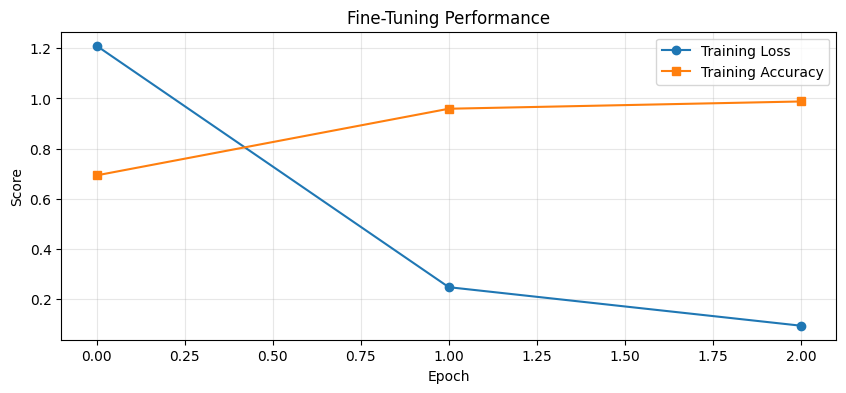

✅ Training complete!


In [ ]:
# CELL 7C: MULTIMODAL FINE-TUNING

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

print("🚀 Initializing Training ...")

# Device Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {DEVICE}")

# 1. DATASET WITH TOKENIZATION
class RealFashionDataset(Dataset):
    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # Create Label Mapping (Category Name -> Integer ID)
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

        print(f"   📦 Training on {self.num_classes} classes: {self.categories[:5]}...")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        try:
            item = self.items[idx]
            image = item['image']
            text = f"A photo of a {item['name']}"

            # 1. Image Transform (Augmentation)
            if self.transform:
                image = self.transform(image)

            # 2. Text Tokenization (CLIP Tokenizer)
            text_inputs = self.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77)

            label_id = self.label_map[item['category']]

            return {
                'image': image,
                'input_ids': text_inputs['input_ids'].squeeze(0),
                'attention_mask': text_inputs['attention_mask'].squeeze(0),
                'label': torch.tensor(label_id, dtype=torch.long)
            }
        except Exception as e:
            print(f"❌ Error at idx {idx}: {type(e).__name__}: {e}")
            # Return next valid sample to prevent crash
            return self.__getitem__((idx + 1) % len(self))

# 2. AUGMENTATION PIPELINE
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 256px thumbnail → 224px for CLIP
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275])
])

# 3. FUSION MODEL
class RealFusionNetwork(nn.Module):
    def __init__(self, backbone_model, num_classes):
        super().__init__()
        self.backbone = backbone_model

        # Freeze Backbone (Transfer Learning)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Fusion Head
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (Image) + 512 (Text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # 1. Get Real Features from Backbone (No Grad)
        with torch.no_grad():
            img_features = self.backbone.get_image_features(pixel_values=images)
            txt_features = self.backbone.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

            # Normalize
            img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
            txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)

        # 2. Concatenate
        combined = torch.cat((img_features, txt_features), dim=1)

        # 3. Classify
        logits = self.fusion_mlp(combined)
        return logits

# 4. TRAINING LOOP
def train_fusion(items, clip_model, clip_processor, epochs=2):
    print(f"🏋️ Starting Real Fine-Tuning (Head Training)...")

    try:
        # Setup Data
        dataset = RealFashionDataset(items, clip_processor, transform=train_transforms)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Setup Model
        model = RealFusionNetwork(clip_model, dataset.num_classes).to(DEVICE)

        # Optimizer (Only optimize the fusion_mlp parameters)
        optimizer = optim.Adam(model.fusion_mlp.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Metric History
        history = {'loss': [], 'accuracy': []}

        model.train()

        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

            for batch in progress_bar:
                # Move to GPU
                images = batch['image'].to(DEVICE)
                input_ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                # Zero Grad
                optimizer.zero_grad()

                # Forward
                outputs = model(images, input_ids, mask)
                loss = criterion(outputs, labels)

                # Backward
                loss.backward()
                optimizer.step()

                # Metrics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})

            avg_loss = epoch_loss / len(dataloader)
            avg_acc = correct / total
            history['loss'].append(avg_loss)
            history['accuracy'].append(avg_acc)

            print(f"   ✅ Epoch {epoch+1} Summary: Loss={avg_loss:.4f}, Accuracy={avg_acc:.4f}")

        return model, history

    except Exception as e:
        print(f"❌ Training failed: {type(e).__name__}: {e}")
        raise

# --- EXECUTE TRAINING ---
if 'clip_encoder' in globals():
    raw_model = clip_encoder.model
    raw_processor = clip_encoder.processor

    trained_fusion_model, train_history = train_fusion(
        processed_items,
        raw_model,
        raw_processor,
        epochs=3
    )

    # Evaluation Plots
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(train_history['loss'], label='Training Loss', marker='o')
    plt.plot(train_history['accuracy'], label='Training Accuracy', marker='s')
    plt.title("Fine-Tuning Performance")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("✅ Training complete!")

else:
    raise RuntimeError("⚠️ 'clip_encoder' not found. Please run Cell 4 first!")

In [ ]:
# CELL 7D: EVALUATION METRICS

from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. DEFINE FUNCTION FIRST
def evaluate_model(model, dataloader, device):
    """Compute Precision, Recall, F1 on validation set"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, mask)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"📊 Evaluation Metrics:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    return {'precision': precision, 'recall': recall, 'f1': f1}

# 2. THEN CREATE DATALOADER AND RUN
eval_dataset = RealFashionDataset(processed_items, raw_processor, transform=train_transforms)
dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

if 'trained_fusion_model' in globals():
    eval_metrics = evaluate_model(trained_fusion_model, dataloader, DEVICE)

   📦 Training on 19 classes: ['cape', 'cardigan', 'coat', 'dress', 'glasses']...
📊 Evaluation Metrics:
   Precision: 0.9825
   Recall:    0.9907
   F1-Score:  0.9863


In [ ]:
# CELL 8: LLM 1B MODEL

import gc
import re
import torch
torch.cuda.empty_cache()
gc.collect()

from unsloth import FastLanguageModel
from typing import List, Dict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1B model i(is the smaller)
LLM_MODEL = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

print("Loading 1B LLM...")

llm_model, llm_tokenizer = FastLanguageModel.from_pretrained(
    model_name=LLM_MODEL,
    max_seq_length=1024,
    load_in_4bit=True,
    dtype=None,
)

FastLanguageModel.for_inference(llm_model)
print(" LLM loaded!")

def generate_response(user_query: str, retrieved_products: List[Dict], intent: str, detected_category: str = None) -> str:

    # --- LAYER 1: CLEAN THE INPUT ---
    product_context_list = []
    for i, p in enumerate(retrieved_products[:5]):
        name = p.get('name', 'Unknown Item')
        category = p.get('category', 'Fashion Item')
        details = p.get('description', 'A great style choice.')
        entry = f"Option {i+1}: {name} ({category}) - {details}"
        product_context_list.append(entry)

    product_context = "\n".join(product_context_list)

    # --- LAYER 2: STRICT PROMPT ---
    # Build context about what user uploaded/searched
    search_context = ""
    if detected_category:
        search_context = f"User uploaded an image of: {detected_category}\n"

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a fashion stylist assistant.
Your Goal: Recommend the items listed below to the user based on their request.

STRICT RULES:
1. Do NOT mention percentages, confidence scores, or numbers like "52%".
2. Do NOT mention "match score" or technical details.
3. Only discuss the style, color, and fabric of the items.
4. Keep the response natural and helpful.
5. ONLY recommend items from the "Available Items" list below - do NOT invent or make up product names.
6. If the available items don't match what the user asked for, honestly say "I couldn't find an exact match, but here are similar options."
7. Do NOT create categories like "Similar Dresses" or "Similar Tops" unless those items actually exist in the Available Items list.<|eot_id|><|start_header_id|>user<|end_header_id|>

{search_context}User Request: "{user_query}"

Available Items (ONLY recommend from this exact list):
{product_context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""

    try:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(DEVICE)
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.6,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=llm_tokenizer.eos_token_id
        )
        raw_response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant")[-1].strip()

        # --- LAYER 3: CLEAN THE OUTPUT ---
        clean_response = re.sub(r'\b\d+%\b', '', raw_response)
        clean_response = re.sub(r'\s+', ' ', clean_response).strip()

        return clean_response

    except Exception as e:
        return f"Check out this option: {retrieved_products[0]['name']}"

print("✅ Ready!")

Loading 1B LLM...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
 LLM loaded!
✅ Ready!


In [ ]:
# CELL 9: Orchestration
import numpy as np
from typing import Dict, List, Optional
import logging
import torch
from transformers import BertTokenizer

logger = logging.getLogger(__name__)
TOP_K_RESULTS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

# Load tokenizer again
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class FashionChatbot:
    """Complete multimodal fashion assistant"""

    def __init__(self, clip_encoder, intent_classifier, search_index, audio_transcriber=None, fusion_model=None):
        self.clip = clip_encoder
        self.intent_model = intent_classifier
        self.index = search_index
        self.audio = audio_transcriber
        self.fusion_model = fusion_model # Add fusion_model to init
        print(" Chatbot ready!")

    def classify_intent(self, text: str) -> str:
        """Classify user intent using BERT model"""
        self.intent_model.eval()
        with torch.no_grad():
            inputs = intent_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
            outputs = self.intent_model(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()
        return INTENT_LABELS.get(pred, "SEARCH")

    def predict_category_fusion(self, image, text):

        if not self.fusion_model:
            return "Unknown"

        # This part assumes a specific structure for fusion_model prediction
        # For now, it's a placeholder. A proper implementation would need
        # to align with the RealFusionNetwork's forward method.
        # Example (simplified, assuming fusion_model expects raw image and tokenized text):
        try:
            # Preprocess image and text similarly to RealFashionDataset __getitem__
            # This might require passing raw_processor to chatbot or making clip_processor accessible
            # For simplicity, using clip encoder here, but fusion model might need different inputs

            # If fusion model needs image processed for it:
            img_processed = self.clip.processor(images=image, return_tensors="pt").pixel_values.to(DEVICE)
            txt_tokenized = self.clip.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(DEVICE)

            with torch.no_grad():
                outputs = self.fusion_model(img_processed, txt_tokenized['input_ids'], txt_tokenized['attention_mask'])
                _, predicted_idx = torch.max(outputs, 1)
                # Need access to the dataset's category list to map idx back to name
                # For now, return a placeholder or 'Unknown'
                return "Predicted_Category_Placeholder" # Replace with actual mapping
        except Exception as e:
            logger.error(f"Fusion model prediction failed: {e}")
            return "Unknown"

    def process_query(self, text: str = None, image = None, audio_path: str = None,
                          weights={'image': 0.50, 'text': 0.35, 'audio': 0.15}) -> Dict:

            # --- 1. PRE-PROCESSING & FUSION (Keep your Weighted Logic) ---
            emb_dim = 512
            img_emb = np.zeros(emb_dim, dtype='float32')
            txt_emb = np.zeros(emb_dim, dtype='float32')
            aud_emb = np.zeros(emb_dim, dtype='float32')
            active_modalities = []
            transcribed_text = ""

            # Process Inputs
            if audio_path and self.audio:
                transcribed_text = self.audio.transcribe_file(audio_path) # Use transcribe_file for path
                if transcribed_text:
                    aud_emb = self.clip.encode_text(transcribed_text)
                    active_modalities.append('audio')
                    if not text: text = transcribed_text

            if text:
                txt_emb = self.clip.encode_text(text)
                active_modalities.append('text')

            if image is not None:
                img_emb = self.clip.encode_image(image)
                active_modalities.append('image')

            if not active_modalities:
                return {"error": "No input", "response": "Please provide input.", "products": []}

            # Weighted Average
            current_weights = {k: weights[k] for k in active_modalities}
            total_weight = sum(current_weights.values())
            final_embedding = np.zeros(emb_dim, dtype='float32')

            if 'image' in active_modalities: final_embedding += img_emb * (weights['image']/total_weight)
            if 'text' in active_modalities: final_embedding += txt_emb * (weights['text']/total_weight)
            if 'audio' in active_modalities: final_embedding += aud_emb * (weights['audio']/total_weight)

            norm = np.linalg.norm(final_embedding)
            if norm > 0: final_embedding = final_embedding / norm

            # --- 2. SEARCH ---
            products = self.index.search(final_embedding, k=TOP_K_RESULTS)

            # --- 3. FILTERING (The Fix) ---
            valid_products = [p for p in products if p['score'] > 0.15]

            intent = self.classify_intent(text if text else "SEARCH")

            if not valid_products:
                 return {
                    "intent": intent,
                    "predicted_category": None,
                    "query": text,
                    "products": [],
                    "response": "I couldn't find any fashion items matching that description. Can you try something else?"
                }

            # --- 4. PREDICTION & GENERATION ---
            predicted_category = "Unknown"
            # Check if fusion_model exists before trying to use it
            if self.fusion_model is not None and image is not None and text is not None:
                try:
                    cat_pred = self.predict_category_fusion(image, text)
                    if cat_pred: predicted_category = cat_pred
                except Exception as e:
                    logger.warning(f"Error during fusion model prediction: {e}")
                    pass # Keep 'Unknown'

            context_text = text if text else transcribed_text
            if predicted_category != "Unknown":
                context_text += f" (Looking for: {predicted_category})"

            # Pass 'valid_products' to the generator
            response_text = generate_response(context_text, valid_products, intent)

            return {
                "intent": intent,
                "predicted_category": predicted_category,
                "query": text,
                "products": valid_products, # Return the filtered list
                "response": response_text
            }

# Initialize
print("🤖 Initializing chatbot...")
chatbot = FashionChatbot(
    clip_encoder=clip_encoder,
    intent_classifier=intent_classifier,
    search_index=search_index,
    audio_transcriber=audio_transcriber if 'audio_transcriber' in globals() else None, # Use globals() to check for variable existence
    fusion_model=trained_fusion_model if 'trained_fusion_model' in globals() else None # Pass the trained fusion model
)

# Test
print("\n📝 Test 1: Text-only query")
result = chatbot.process_query(text="I need a casual summer outfit")
print(f"Intent: {result['intent']}")
print(f"Products found: {len(result['products'])}")
print(f"Response: {result['response'][:200]}...")

🤖 Initializing chatbot...
 Chatbot ready!

📝 Test 1: Text-only query
Intent: RECOMMEND
Products found: 5
Response: Based on your request for a casual summer outfit, I would suggest: * Option 2: Dress dress This is a simple yet stylish option that's perfect for a casual summer day. The dress is lightweight, breatha...


In [ ]:
!pip install audio-recorder-streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 54.8 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 5.5.0
    Uninstalling altair-5.5.0:
      Successfully uninstalled altair-5.5.0


In [ ]:
%%writefile app.py
# app.py - Multimodal Fashion Assistant

import streamlit as st
import torch
import numpy as np
from PIL import Image
import faiss
import pickle
import io
import tempfile
import librosa
from audio_recorder_streamlit import audio_recorder
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration
from sentence_transformers import SentenceTransformer
from unsloth import FastLanguageModel

st.set_page_config(page_title="Fashion Assistant", layout="wide", page_icon="👗")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===== CACHED MODEL LOADING =====
@st.cache_resource
def load_prebuilt_data():
    with open('fashion_data.pkl', 'rb') as f:
        data = pickle.load(f)
    image_index = faiss.deserialize_index(data['image_index'])
    text_index = faiss.deserialize_index(data['text_index'])
    products = []
    for p in data['products']:
        prod = {'name': p['name'], 'category': p['category']}
        if p.get('image_bytes'):
            prod['image'] = Image.open(io.BytesIO(p['image_bytes']))
        products.append(prod)
    return image_index, text_index, products

@st.cache_resource
def load_clip():
    clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return clip, proc

@st.cache_resource
def load_sentence_transformer():
    return SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

@st.cache_resource
def load_whisper():
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to(DEVICE)
    proc = WhisperProcessor.from_pretrained("openai/whisper-base")
    return model, proc

@st.cache_resource
def load_llm():
    llm, tok = FastLanguageModel.from_pretrained(
        "unsloth/Llama-3.2-1B-Instruct-bnb-4bit", max_seq_length=512, load_in_4bit=True
    )
    FastLanguageModel.for_inference(llm)
    return llm, tok

# Load models
with st.spinner("🔄 Loading models... Please wait"):
    image_index, text_index, products = load_prebuilt_data()
    clip, clip_proc = load_clip()
    text_encoder = load_sentence_transformer()
    whisper, whisper_proc = load_whisper()
    llm, llm_tok = load_llm()

# ===== HELPER FUNCTIONS =====
def encode_image(img):
    inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        e = clip.get_image_features(**inputs)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_text_clip(text):
    q = clip_proc(text=["a photo of " + text], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        e = clip.get_text_features(**q)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_text_sentence(text):
    e = text_encoder.encode([text], normalize_embeddings=True)
    return e

def classify_uploaded_image(img):
    """Use CLIP to detect what category the uploaded image is"""
    categories = [
        "jacket", "coat", "blazer", "dress", "skirt", "pants", "jeans",
        "shirt", "blouse", "top", "sweater", "shoes", "boots", "bag",
        "accessories", "hat", "scarf"
    ]

    text_inputs = clip_proc(
        text=[f"a photo of a {cat}" for cat in categories],
        return_tensors="pt",
        padding=True
    ).to(DEVICE)

    image_inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        image_features = clip.get_image_features(**image_inputs)
        text_features = clip.get_text_features(**text_inputs)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).softmax(dim=-1)
        best_idx = similarity.argmax().item()

    return categories[best_idx]


def transcribe_audio(audio_bytes):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
            f.write(audio_bytes)
            audio, sr = librosa.load(f.name, sr=16000)
        inputs = whisper_proc(audio, sampling_rate=16000, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            ids = whisper.generate(**inputs)
        return whisper_proc.batch_decode(ids, skip_special_tokens=True)[0]
    except Exception as e:
        return None

def build_context(messages, max_turns=5):
    recent = messages[-max_turns*2:] if len(messages) > max_turns*2 else messages
    context = ""
    for msg in recent:
        role = "User" if msg["role"] == "user" else "Assistant"
        context += role + ": " + msg["text"] + chr(10)
    return context

def is_meta_command(text):
    meta_phrases = [
        "similar to the image", "like this", "like the image",
        "find similar", "search similar", "match this",
        "something like this", "this style", "similar to this",
        "like the photo", "similar to the photo", "match the image",
        "parecido", "similar", "como este", "como la imagen"
    ]
    text_lower = text.lower()
    return any(phrase in text_lower for phrase in meta_phrases)

def generate_response(query, prods, context="",detected_category=None):
    prod_list = ", ".join([p["name"] for p in prods[:3]])

    prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    prompt += "You are a helpful fashion assistant. Give brief, friendly suggestions based on the products found. "
    prompt += "Use the conversation context to understand user preferences (gender, style, occasion). "
    prompt += "Never refuse reasonable fashion requests.<|eot_id|>"
    prompt += "<|start_header_id|>user<|end_header_id|>"

    if context:
        prompt += "Conversation history:" + chr(10) + context + chr(10) + chr(10)

    prompt += "Current request: " + query + chr(10)
    prompt += "Available products: " + prod_list
    prompt += "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    try:
        out = llm.generate(**llm_tok(prompt, return_tensors="pt").to(DEVICE), max_new_tokens=150)
        response = llm_tok.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()
        return response if response else "Here are some options that might interest you!"
    except:
        return "Here are some fashion items I found for you!"

def do_search(text_q, img_q, voice_q):
    """Execute dual-index search and return results"""
    results = []
    final_text = ""
    query_desc_parts = []

    text_is_meta = text_q and is_meta_command(text_q)

    # === IMAGE SEARCH (using image_index) ===
    if img_q is not None:
        img_emb = encode_image(img_q)
        img_scores, img_ids = image_index.search(img_emb, 10)
        query_desc_parts.append("📷 Image")

        for s, i in zip(img_scores[0], img_ids[0]):
            if 0 <= i < len(products):
                p = products[i].copy()
                p["similarity"] = max(0, min(100, float(s) * 100))
                p["source"] = "image"
                results.append(p)

    # === TEXT SEARCH (using text_index with SentenceTransformer) ===
    text_for_search = ""
    if voice_q:
        text_for_search = voice_q
        query_desc_parts.append("🎤 Voice")
    if text_q and not text_is_meta:
        text_for_search = (text_for_search + " " + text_q).strip()
        query_desc_parts.append("📝 Text")

    if text_for_search:
        txt_emb = encode_text_sentence(text_for_search)
        txt_scores, txt_ids = text_index.search(txt_emb, 10)

        for s, i in zip(txt_scores[0], txt_ids[0]):
            if 0 <= i < len(products):
                p = products[i].copy()
                p["similarity"] = max(0, min(100, float(s) * 100))
                p["source"] = "text"
                results.append(p)

    if not results:
        return None, None, None, None

    # Merge and deduplicate results (prefer higher similarity)
    seen = {}
    for p in results:
        name = p["name"]
        if name not in seen or p["similarity"] > seen[name]["similarity"]:
            seen[name] = p

    merged = sorted(seen.values(), key=lambda x: x["similarity"], reverse=True)[:5]

    final_text = text_for_search if text_for_search else "Similar items to uploaded image"
    query_desc = " + ".join(query_desc_parts)

    return merged, final_text, query_desc, None

# ===== SESSION STATE =====
if "messages" not in st.session_state:
    st.session_state.messages = []
if "current_image" not in st.session_state:
    st.session_state.current_image = None
if "current_voice" not in st.session_state:
    st.session_state.current_voice = None
if "current_text" not in st.session_state:
    st.session_state.current_text = ""
if "file_uploader_key" not in st.session_state:
    st.session_state.file_uploader_key = 0
if "audio_processed" not in st.session_state:
    st.session_state.audio_processed = False
if "image_processed" not in st.session_state:
    st.session_state.image_processed = False
if "auto_search_voice" not in st.session_state:
    st.session_state.auto_search_voice = False
if "auto_search_image" not in st.session_state:
    st.session_state.auto_search_image = False
if "last_search_results" not in st.session_state:
    st.session_state.last_search_results = []
if "last_search_context" not in st.session_state:
    st.session_state.last_search_context = ""

# ===== MAIN UI =====
st.title("👗 Fashion Assistant")
st.caption("🛍️ " + str(len(products)) + " products loaded | Multimodal Search: Text, Image & Voice")

# ===== SIDEBAR =====
with st.sidebar:
    st.header("🎯 How to Search")

    st.info("""
    **Use any input method:**
    - 📝 **Text** - Describe what you want
    - 📷 **Image** - Upload a photo (auto-search)
    - 🎤 **Voice** - Record your request (auto-search)

    **Or combine them** for better results!
    """)

    st.divider()

    # --- TEXT INPUT ---
    st.subheader("📝 Text Query")
    text_input = st.text_area(
        "Describe what you want",
        value=st.session_state.current_text,
        placeholder="e.g., blue summer dress, casual jacket for wedding...",
        height=80,
        key="text_area_" + str(st.session_state.file_uploader_key),
        help="Type any fashion item, style, or occasion"
    )
    if text_input:
        st.session_state.current_text = text_input.strip()

    st.divider()

    # --- IMAGE INPUT (AUTO-SEARCH) ---
    st.subheader("📷 Image Search")
    st.caption("Upload a photo → Auto search similar items")
    uploaded_image = st.file_uploader(
        "Upload fashion image",
        type=["jpg", "jpeg", "png"],
        key="img_" + str(st.session_state.file_uploader_key),
        help="Upload a photo to find similar styles automatically"
    )

    if uploaded_image and not st.session_state.image_processed:
        img = Image.open(uploaded_image).convert("RGB")
        st.session_state.current_image = img
        st.image(img, caption="✅ Image loaded - Searching...", use_container_width=True)
        st.session_state.image_processed = True
        st.session_state.auto_search_image = True
        st.rerun()
    elif st.session_state.current_image:
        st.image(st.session_state.current_image, caption="✅ Current image", use_container_width=True)

    st.divider()

    # --- VOICE INPUT ---
    st.subheader("🎤 Voice Input")

    # Option 1: Live Recording
    st.caption("🔴 Record your voice:")
    audio_bytes = audio_recorder(
        text="Click to record",
        recording_color="#e74c3c",
        neutral_color="#6c757d",
        icon_size="2x",
        pause_threshold=2.0
    )

    if audio_bytes and not st.session_state.audio_processed:
        st.audio(audio_bytes, format="audio/wav")
        with st.spinner("🎙️ Transcribing..."):
            transcribed = transcribe_audio(audio_bytes)
            if transcribed and transcribed.strip():
                st.session_state.current_voice = transcribed.strip()
                st.session_state.audio_processed = True
                st.success("✅ " + transcribed)
                st.session_state.auto_search_voice = True
                st.rerun()
            else:
                st.error("❌ Could not transcribe. Try again.")

    st.divider()

    # Option 2: File Upload
    st.caption("📁 Or upload an audio file:")
    uploaded_audio = st.file_uploader(
        "Upload voice recording",
        type=["wav", "mp3", "m4a", "mp4", "ogg", "webm"],
        key="audio_" + str(st.session_state.file_uploader_key),
        help="Supports WAV, MP3, M4A, MP4, OGG, WEBM"
    )

    if uploaded_audio and not st.session_state.audio_processed:
        st.audio(uploaded_audio)
        with st.spinner("🎙️ Transcribing..."):
            transcribed = transcribe_audio(uploaded_audio.read())
            if transcribed and transcribed.strip():
                st.session_state.current_voice = transcribed.strip()
                st.session_state.audio_processed = True
                st.success("✅ " + transcribed)
                st.session_state.auto_search_voice = True
                st.rerun()
            else:
                st.error("❌ Could not transcribe audio.")

    if st.session_state.current_voice:
        st.success("🎤 " + st.session_state.current_voice)

    # --- ACTIVE INPUTS SUMMARY ---
    active_inputs = []
    if st.session_state.current_text:
        active_inputs.append("📝 Text")
    if st.session_state.current_image:
        active_inputs.append("📷 Image")
    if st.session_state.current_voice:
        active_inputs.append("🎤 Voice")

    if active_inputs:
        st.success("**Active inputs:** " + " + ".join(active_inputs))
    else:
        st.warning("💡 Add text, image, or voice to search")

    # --- BUTTONS ---
    col1, col2 = st.columns(2)
    with col1:
        search_button = st.button("🔍 Search", type="primary", use_container_width=True)
    with col2:
        clear_button = st.button("🗑️ Clear All", use_container_width=True)

    if clear_button:
        st.session_state.messages = []
        st.session_state.current_image = None
        st.session_state.current_voice = None
        st.session_state.current_text = ""
        st.session_state.audio_processed = False
        st.session_state.image_processed = False
        st.session_state.auto_search_voice = False
        st.session_state.auto_search_image = False
        st.session_state.file_uploader_key += 1
        st.rerun()

    st.divider()
    st.caption("💡 **Tip:** The more inputs you provide, the better the results!")

# ===== CHAT HISTORY =====
for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["text"])
        if msg.get("products"):
            # Always create 5 columns for consistent sizing
            cols = st.columns(5)
            for i, p in enumerate(msg["products"][:5]):
                with cols[i]:
                    if p.get("image"):
                        # Fixed width instead of container width
                        st.image(p["image"], width=120)
                    st.caption(p["name"][:20] + "..." if len(p["name"]) > 20 else p["name"])
                    similarity = int(min(100, max(0, p.get("similarity", 50))))
                    st.progress(similarity)
                    st.caption(str(similarity) + "% match")

# ===== AUTO-SEARCH: IMAGE =====
if st.session_state.auto_search_image and st.session_state.current_image:
    st.session_state.auto_search_image = False

    # Detect what the image is
    detected_category = classify_uploaded_image(st.session_state.current_image)

    results, final_text, query_desc, _ = do_search("", st.session_state.current_image, "")

    if results:
        st.session_state.messages.append({"role": "user", "text": f"📷 [Image search: {detected_category}]"})

        context = build_context(st.session_state.messages)

        # FIXED: Use correct parameter names
        response = generate_response(
            query=f"Find items similar to this {detected_category}",
            prods=results,
            context=context,
            detected_category=detected_category
        )

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })
        st.session_state.current_image = None
        st.session_state.image_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

# ===== AUTO-SEARCH: VOICE =====
if st.session_state.auto_search_voice and st.session_state.current_voice:
    st.session_state.auto_search_voice = False

    # Check if query references previous search ("this", "these", "the outfit", etc.)
    voice_lower = st.session_state.current_voice.lower()
    is_followup = any(phrase in voice_lower for phrase in ["this outfit", "these", "match this", "go with", "pair with", "complement"])

    # If follow-up, search for complementary items (shoes if prev was jeans, etc.)
    search_query = st.session_state.current_voice
    if is_followup and st.session_state.last_search_results:
        # Extract what user wants (shoes, accessories, etc.)
        if "shoe" in voice_lower:
            search_query = "shoes footwear sneakers"
        elif "accessor" in voice_lower:
            search_query = "accessories belt bag"
        elif "top" in voice_lower or "shirt" in voice_lower:
            search_query = "shirt top blouse"

    results, final_text, query_desc, _ = do_search(search_query, None, "")

    if results:
        st.session_state.messages.append({"role": "user", "text": "🎤 " + st.session_state.current_voice})
        context = build_context(st.session_state.messages)
        # Pass previous results for context
        response = generate_response(final_text, results, context, st.session_state.last_search_results)

        # Update last results
        st.session_state.last_search_results = results

# ===== MANUAL SEARCH BUTTON =====
if search_button:
    text_q = st.session_state.current_text
    img_q = st.session_state.current_image
    voice_q = st.session_state.current_voice

    if not text_q and not img_q and not voice_q:
        st.warning("⚠️ Please add at least one input (text, image, or voice)!")
    else:
        results, final_text, query_desc, _ = do_search(text_q, img_q, voice_q)

        if results:
            user_msg_parts = []
            if voice_q:
                user_msg_parts.append("🎤 " + voice_q)
            if text_q:
                user_msg_parts.append("📝 " + text_q)
            if img_q:
                user_msg_parts.append("📷 [image]")
            user_msg = " | ".join(user_msg_parts)

            st.session_state.messages.append({"role": "user", "text": user_msg})

            context = build_context(st.session_state.messages)
            response = generate_response(final_text, results, context)

            st.session_state.messages.append({
                "role": "assistant",
                "text": response,
                "products": results
            })

            st.session_state.current_image = None
            st.session_state.current_voice = None
            st.session_state.current_text = ""
            st.session_state.audio_processed = False
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1
            st.rerun()
        else:
            st.error("❌ No results found. Try a different search.")

# ===== QUICK CHAT INPUT =====
st.divider()
prompt = st.chat_input("💬 Quick text search (or use sidebar for multimodal)")

if prompt:
    img_q = st.session_state.current_image

    results, final_text, query_desc, _ = do_search(prompt, img_q, None)

    if results:
        user_msg = prompt
        if img_q:
            user_msg += " 📷"

        st.session_state.messages.append({"role": "user", "text": user_msg})

        context = build_context(st.session_state.messages)
        response = generate_response(final_text, results, context)

        st.session_state.messages.append({
            "role": "assistant",
            "text": response,
            "products": results
        })

        if img_q:
            st.session_state.current_image = None
            st.session_state.image_processed = False
            st.session_state.file_uploader_key += 1

        st.rerun()
    else:
        st.warning("No results found. Try different keywords.")

Overwriting app.py


In [ ]:
# CELL 11: STREAMLIT WITH NGROK

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time


NGROK_TOKEN = "374PsiGvVhW7UqpMna673SvzuWP_3EpvNX9W4uxYFo2iccwBX"

if NGROK_TOKEN:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing Streamlit processes
!pkill -f streamlit

# Start Streamlit in background
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Waiting to start
time.sleep(5)

# Create ngrok tunnel
try:
    # Close existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"\n Fashion Chatbot is live at:")
    print(f"   {public_url}")
    print(f"\n Note: Give some time while models initialize")

except Exception as e:
    print(f"❌ Failed to create tunnel: {e}")
    print("Alternative: Use localtunnel with: !npx localtunnel --port 8501")


 Fashion Chatbot is live at:
   NgrokTunnel: "https://2d507dc13948.ngrok-free.app" -> "http://localhost:8501"

 Note: Give some time while models initialize
